# Declarative Node Worked Examples

In this notebook we explore four simple examples of declarative nodes.
The first example explores an unconstrained scalar-input/scalar-output problem,
the second example solves a problem with linear objective and unit sphere constraint,
the third example solves a problem with quadratic objective and unit sphere constraint,
and the last example solve a problem with quadratic objective and unit ball constraint.
All examples have one- or two-dimensional output to allow for easy visualization.

It is assumed that you have read the ["Deep Declarative Networks: A New Hope"](https://arxiv.org/abs/1909.04866) paper.

In [1]:
%matplotlib notebook

In [2]:
import autograd.numpy as np
from autograd import grad
from autograd import jacobian
from scipy.linalg import cho_factor, cho_solve

import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

import warnings
warnings.filterwarnings('ignore')

## Example 1: One-dimensional unconstrained polynomial

In this example we explore minimization of a one-dimensional parametrized polynomial from [Gould et al., 2016](https://arxiv.org/abs/1607.05447). Here the problem is
$$
y(x) = \text{argmin}_u \; f(x, u)
$$
where $f(x, u) = xu^4 + 2x^2u^3 - 12u^2$ with $x, u \in \mathbb{R}$.

For fixed $x$, we can easily solve for the stationary points of the polynomial as
$$
\begin{align*}
0 &= \frac{d}{du} f(x, u) \\
&= 4xu^3 + 6x^2u^2 - 24u \\
&= 2u(2xu^2 + 3x^2u - 12) \\
\end{align*}
$$
Therefore the stationary points are at
$$
u \in \left\{0, \frac{-3x^2 - \sqrt{9x^4 + 96x}}{4x}, \frac{-3x^2 + \sqrt{9x^4 + 96x}}{4x} \right\}
$$
For $x > 0$ one of these will be the global minimum, $y$. The others are either local minimum, local maximum or inflection points depending on the value of $x$. We can therefore evaluate all three stationary points to determine the global minimum as done in the `solve` function below.

In [3]:
def f(x, u):
    return x * u ** 4.0 + 2 * x ** 2.0 * u ** 3.0 - 12.0 * u ** 2.0

def solve(x):
    delta = np.sqrt(9.0 * x ** 4.0 + 96.0 * x)
    y_stationary = [0.0, (-3.0 * x ** 2.0 - delta) / (4.0 * x), (-3.0 * x ** 2.0 + delta) / (4.0 * x)]
    y_min_indx = np.argmin([f(x, y) for y in y_stationary])
    return y_stationary[y_min_indx]

### Visualization

The following shows a contour plot of the function $f(x, u)$ for $0.25 \leq x \leq 2.25$ and $-6 \leq u \leq 4$. Only negative contour lines are shown to highlight the shape of the function around the minima. The black dashed line depicts the valley in which we find the global minima for each $x$. Over this range it turns out that the global minimum is
$$
y(x) = \frac{-3x^2 - \sqrt{9x^4 + 96x}}{4x}
$$

<IPython.core.display.Javascript object>


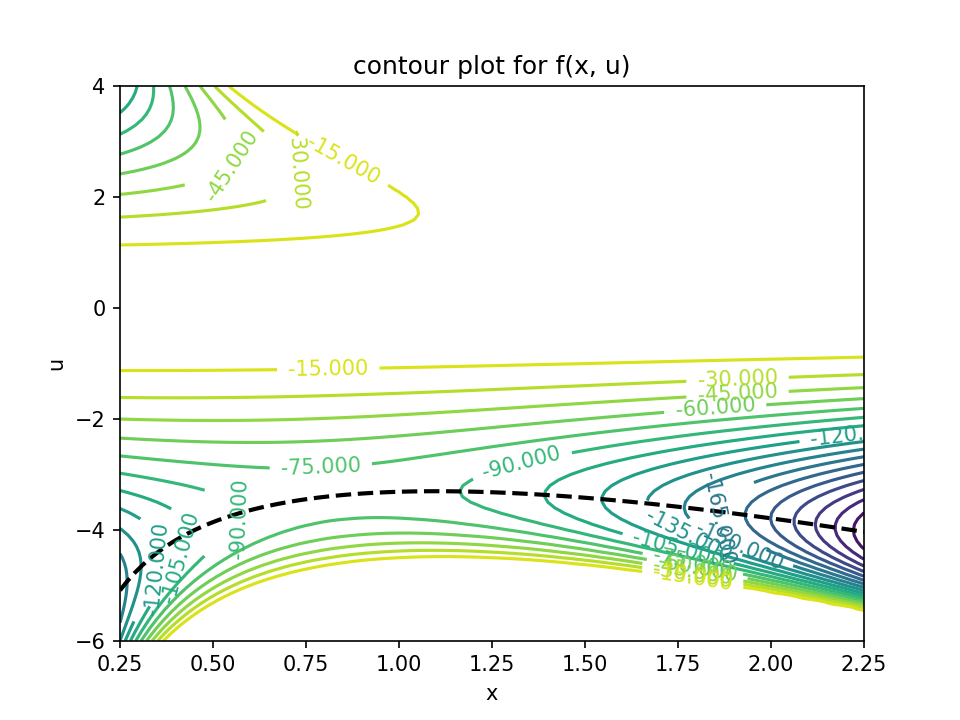

In [4]:
x = np.linspace(0.25, 2.25, 101)
u = np.linspace(-6.0, 4.0, 101)

X, Y = np.meshgrid(x, u)
Z = np.empty(X.shape)

for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i, j] = min(f(X[i, j], Y[i, j]), 0)

plt.figure()
cs = plt.contour(X, Y, Z, 20)
plt.clabel(cs, inline=1, fontsize=10)
plt.plot(x, [solve(xi) for xi in x], 'k--', linewidth=2)
plt.title('contour plot for f(x, u)'); plt.xlabel('x'); plt.ylabel('u')
plt.show()

### Animation

In order to get a better feel for how $y = \text{argmin}_u \, f(x, u)$ changes as a function of $x$ we can animate the function sweeping from $x = 0.25$ to $x = 2.25$. The righthand plot shows $f(x, u)$ as a function of $u$ for fixed $x$ with the global minimum identified by red dashed lines.

In [5]:
%%capture
fig = plt.figure()
ax = [plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)]

def animate(fnum, x, u):
    # clear axes
    ax[0].clear(); ax[1].clear()

    # find minimum of f(x, u) for given x
    y = solve(x[fnum])

    # plot contour and show value of x
    cs = ax[0].contour(X, Y, Z, 20)
    plt.clabel(cs, inline=1, fontsize=10)
    ax[0].plot(x, [solve(xi) for xi in x], 'k--', linewidth=2)
    ax[0].plot([x[fnum], x[fnum]], ax[0].get_ylim(), 'k-', linewidth=2)
    ax[0].set_xlabel('x'); ax[0].set_ylabel('u'); ax[0].set_title('f(x, u)')

    # plot f(x, u) as a function of u for given x
    ax[1].plot(u, [f(x[fnum], ui) for ui in u], 'k-', linewidth=2)
    ax[1].set_ylim([-300, 300])
    ax[1].plot([y, y], ax[1].get_ylim(), 'r--')
    ax[1].plot([u[0], u[-1]], [f(x[fnum], y), f(x[fnum], y)], 'r--')
    ax[1].set_xlabel('u'); ax[1].set_title('f(x = {:0.2f}, u)'.format(x[fnum]))

    return ax

ani = animation.FuncAnimation(fig, animate, fargs=(x, u), interval=100, frames=len(x), blit=False, repeat=False)
plt.close(fig)

In [6]:
# display using video or javascript
HTML(ani.to_html5_video())
#HTML(ani.to_jshtml())

### Gradient

Since we have a closed-form solution for $y$ in terms of $x$ we can compute the gradient directly, i.e.,
$$
\begin{align*}
\frac{dy}{dx}
&= \frac{d}{dx} \left( \frac{-3x^2 - \sqrt{9x^4 + 96x}}{4x} \right) \\
&= -\frac{3}{4} - \frac{9x^3 - 48}{4x\sqrt{9x^4 + 96x}}
\end{align*}
$$

Alternatively, we can make use of the implicit function theorem
$$
\begin{align*}
\frac{dy}{dx}
&= -\left( \frac{\partial^2 f}{\partial u^2}(x, y) \right)^{-1} \frac{\partial^2 f}{\partial x \partial u}(x, y) \\
&= -\left(12xy^2 + 12x^2y - 24\right)^{-1} \left( 4y^3 + 12xy^2\right) \\
&= - \frac{y^3 + 3xy^2}{3xy^2 + 3x^2y - 6}
\end{align*}
$$

As an aside, the result for the implicit function theorem holds for the gradient of any stationary point but we are only interested in the global minima here. Note also that we have used $\frac{dy}{dx}$ notation for gradients. In the following examples we switch to $\text{D}y$ notation since the arguments and outputs are no longer scalars.

The following plot shows $y(x)$ and $\frac{dy}{dx}$ for $0.25 \leq x \leq 2.25$.

<IPython.core.display.Javascript object>


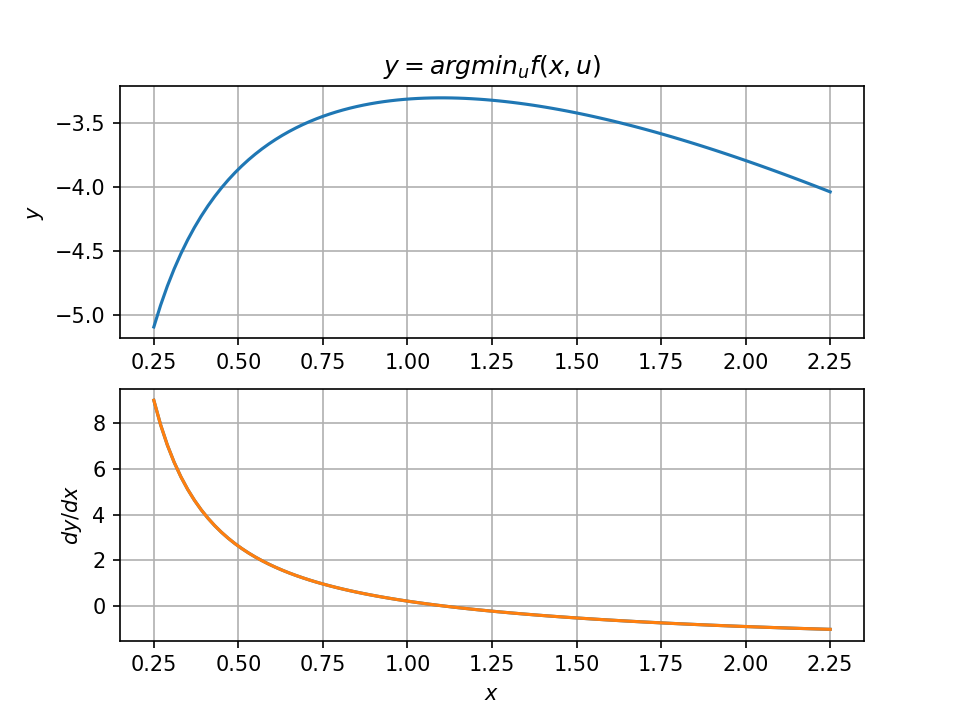

In [7]:
def gradient_by_closed_form(x):
    """Compute the gradient using the closed-form expression."""
    delta = np.sqrt(9.0 * x ** 4 + 96.0 * x)
    return -0.75 - (9.0 * x ** 3 - 48.0) / (4 * x * delta)

def gradient_by_ift(x, y):
    """Compute the gradient using the implicit function theorem result."""
    return -1.0 * (y ** 3 + 3.0 * x * y ** 2) / (3.0 * x * y ** 2 + 3.0 * x ** 2 * y - 6.0)

y = [solve(xi) for xi in x]


plt.figure()
plt.subplot(2, 1, 1)
plt.plot(x, y)
plt.grid()
plt.title(r'$y = argmin_u f(x, u)$'); plt.ylabel(r'$y$')

plt.subplot(2, 1, 2)
plt.plot(x, [gradient_by_closed_form(xi) for xi in x])
plt.plot(x, [gradient_by_ift(xi, yi) for xi, yi in zip(x, y)])
plt.xlabel(r'$x$'); plt.ylabel(r'$dy/dx$')
plt.grid()

plt.show()

### Automatic differentiation

Instead of deriving the Hessian $\frac{\partial^2 f}{\partial u^2}$ and mixed partial deriavtive $\frac{\partial^2 f}{\partial x \partial u}$ by hand we can also use Python's `autograd` module. However, this requires re-writing the objective function `f(x, u)` using `numpy` operators as the following code demonstrates.

<IPython.core.display.Javascript object>


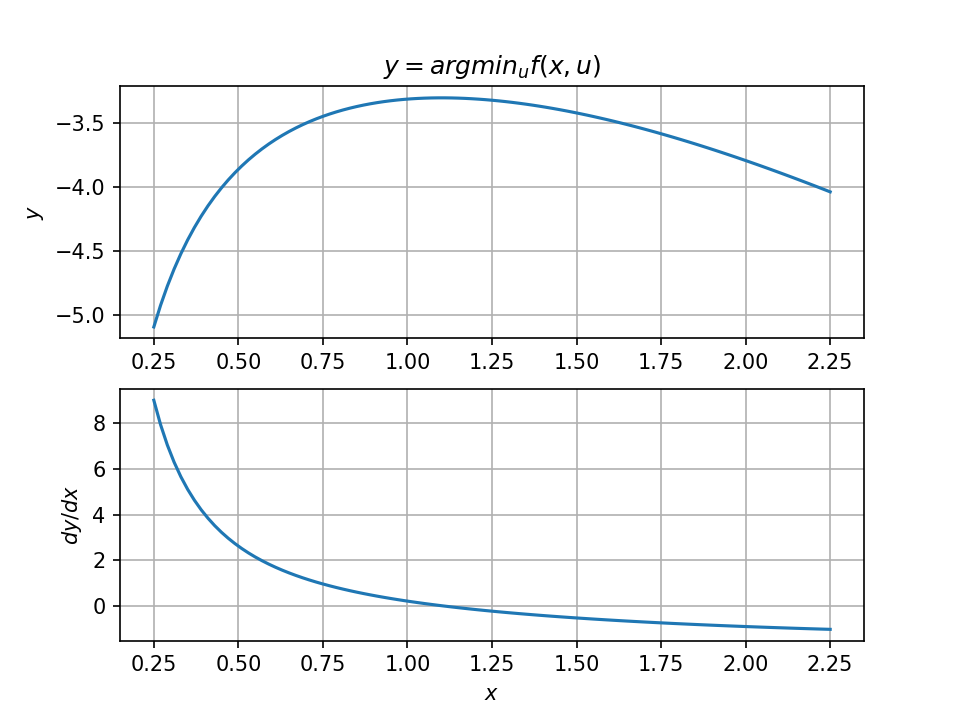

In [8]:
def f(x, u):
    return x * np.power(u, 4.0) + 2 * np.power(x, 2.0) * np.power(u, 3.0) - 12.0 * np.power(u, 2.0)

def gradient_by_auto_diff(x, y):
    fY = grad(f, 1)
    fXY = jacobian(fY, 0)
    fYY = jacobian(fY, 1)

    return -1.0 * fXY(x, y) / fYY(x, y)

plt.figure()
plt.subplot(2, 1, 1); plt.plot(x, y); plt.grid()
plt.title(r'$y = argmin_u f(x, u)$'); plt.ylabel(r'$y$')

plt.subplot(2, 1, 2); plt.plot(x, [gradient_by_auto_diff(xi, yi) for xi, yi in zip(x, y)]); plt.grid()
plt.xlabel(r'$x$'); plt.ylabel(r'$dy/dx$')

plt.show()

## Example 2: Minimize linear objective over unit circle

Consider the problem of minimizing a linear function with solution constrained to lie on the unit circle,
$$
\begin{array}{rll}
y(x) =& \text{argmin}_u & (1, x)^T u
\\
& \text{subject to} & \|u\|_2^2 = 1
\end{array}
$$
where $x \in \mathbb{R}$ and $y(x) \in \mathbb{R}^2$. Here the problem is an instance of a deep declarative node with a single fixed equality constraint as discussed in Section 4.4 of ["Deep Declarative Networks: A New Hope"](https://arxiv.org/abs/1909.04866).

This problem has a closed-form solution and gradient
$$
\begin{align*}
y &= \frac{-1}{\sqrt{1 + x^2}} \begin{bmatrix} 1 \\ x \end{bmatrix} \\
\text{D}y &= \begin{bmatrix} \frac{\text{d}y_1}{\text{d}x} \\ \frac{\text{d}y_2}{\text{d}x} \end{bmatrix}
= \frac{1}{(1 + x^2)^{3/2}} \begin{bmatrix} x \\ -1 \end{bmatrix}
\end{align*}
$$
which we have implemented in the code below.

In [9]:
# objective and constraint functions

def f(x, u):
    """Objective function taking x \in \reals, u \in \reals^2."""
    return np.dot(u, np.array([1.0, x]))

def h(u):
    """Constraint function taking u \in \reals^2."""
    return np.dot(u, u) - 1.0

# analytical solutions

def solve(x):
    """Analytical solution to min. f s.t. h = 0. Returns both optimal primal and dual variables."""
    return -1.0 / np.sqrt(1.0 + x**2.0) * np.array([1.0, x]), -0.5 * np.sqrt(1 + x**2.0)

def dy_closed_form(x):
    """Analytical derivative of y with respect to x."""
    return 1.0 / np.power(1 + x**2.0, 1.5) * np.array([x, -1.0])

The plot below visualizes the problem for $x = 1$. Here we draw contour lines for the linear function (dashed blue) with direction of increasing value depicted by the (blue) arrow. The unit circle (red dashed) illustrates the constraint set and the solution (i.e., point that minimizes $f(x, \cdot)$ over the constraint set) is shown as a (red) dot.

<IPython.core.display.Javascript object>


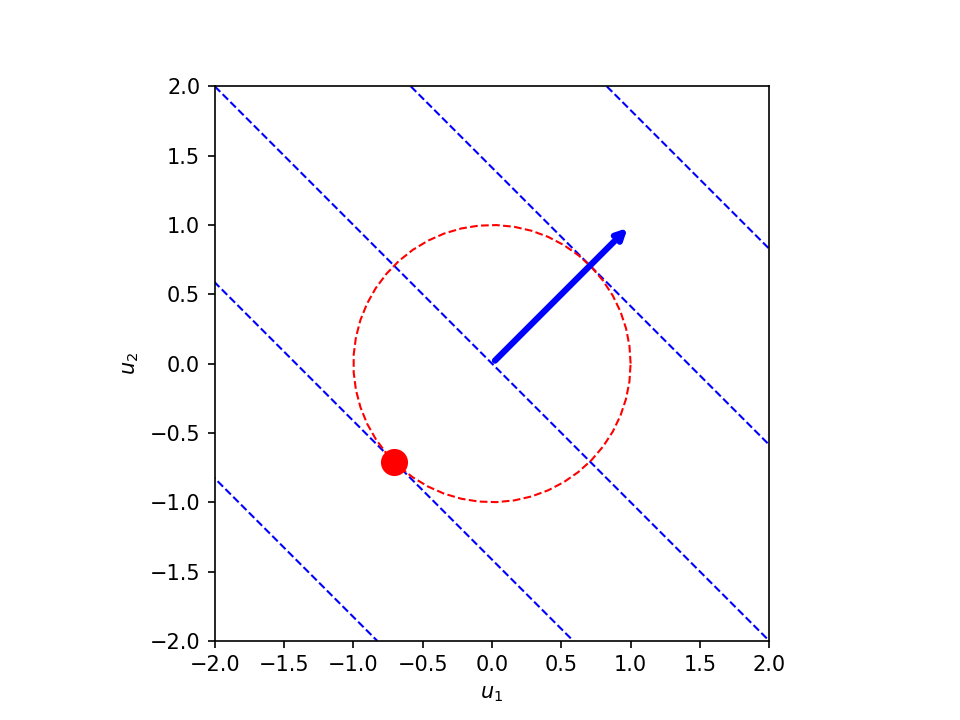

In [10]:
def viz_problem(x, y, ax):
    
    ax.annotate("", xy=(1.0, x), xytext=(0, 0), arrowprops = dict(arrowstyle="->", linewidth=3, color='b'))    
    for delta in np.linspace(-2.0, 2.0, 5):
        dx = delta * np.sqrt(1.0 + x**2.0)
        ax.plot([-2.0 * x + dx, 2.0 * x + dx], [2.0, -2.0], 'b--', linewidth=1)

    ax.plot(np.cos(np.linspace(0.0, 2.0 * np.pi)), np.sin(np.linspace(0.0, 2.0 * np.pi)), 'r--', linewidth=1)
    ax.plot(y[0], y[1], 'ro', markersize=12, linewidth=2)
    ax.set_xlabel(r"$u_1$"); ax.set_ylabel(r"$u_2$")

plt.figure()
a = plt.gca()
x = 1.0
y, _ = solve(x)
viz_problem(x, y, a)
a.axis('square'); a.set_xlim(-2, 2); a.set_ylim(-2, 2)
plt.show()

Above we compute the gradient in closed-form. It can also be computed using implicit differentiation on the first-order optimality condition of the Lagrangian,

$$
\begin{align*}
0 &= 
\text{D} \begin{bmatrix}
    \text{D}_{Y} {\cal L}(x, y, \lambda) \\
    \text{D}_{\Lambda} {\cal L}(x, y, \lambda)
\end{bmatrix}
\\
&=
\text{D} \begin{bmatrix}
    \text{D}_Y f(x, y) - \lambda \text{D}_Y h(y) \\
    h(y)
\end{bmatrix}
\\
&=
\begin{bmatrix}
    \text{D}^2_{XY} f(x, y) + \text{D}^2_{YY} f(x, y) \text{D}y - \lambda \text{D}^2_{YY} h(y) \text{D}y - (\text{D}_Y h(y))^T \text{D}\lambda \\
    \text{D}_{Y} h(y) \text{D}y
\end{bmatrix}
\\
&=
\begin{bmatrix}
    \text{D}^2_{XY} f(x, y) \\
    0
\end{bmatrix}
+
\begin{bmatrix}
    \text{D}^2_{YY} f(x, y) - \lambda \text{D}^2_{YY} h(y) & -(\text{D}_Y h(y))^T \\
    \text{D}_{Y} h(y) & 0
\end{bmatrix}
\begin{bmatrix}
    \text{D}y \\
    \text{D}\lambda
\end{bmatrix}
\\
&=
\begin{bmatrix}
    b \\
    0
\end{bmatrix}
+
\begin{bmatrix}
    H & -a \\
    a^T & 0
\end{bmatrix}
\begin{bmatrix}
    \text{D}y \\
    \text{D}\lambda
\end{bmatrix}
\end{align*}
$$

Block elimination then gives

$$
\begin{align*}
\text{D} y
&= \left( \frac{H^{-1}aa^TH^{-1}}{a^T H^{-1} a} - H^{-1}\right) b \\
&= \frac{v^T b}{v^T a} v - w
\end{align*}
$$

where $v = H^{-1}a$ and $w = H^{-1}b$, and which we have implemented below using automatic differentiation.

In [11]:
# gradient by implicit differentiation

fY = grad(f, 1)
hY = grad(h)
fXY = jacobian(fY, 0)
fYY = jacobian(fY, 1)
hYY = jacobian(hY, 0)

def dy(x):
    """Compute gradient of y with respect to x using implicit differentiation."""

    y, nu = solve(x)

    # Here we solve a system of linear equations rather than inverting H. The linear
    # algebra solver gives $w = H^{-1} D_Y h$ and $v = H^{-1} D^2_{XY} f$ from which
    # we compute Dy(x) as (w^T D^2_{XY} f / w^T D_{Y} h) w - v. 
    a = hY(y)
    b = fXY(x, y)
    H = fYY(x, y) - nu * hYY(y)
    
    (v, w) = np.linalg.solve(H, np.stack((a, b)))
    return v.dot(b) / v.dot(a) * v - w

The following compares the analytic gradient against the gradient derived implicitly over the range $x \in [-2, 2]$.

In [12]:
# generate data for different input
x = np.linspace(-2.0, 2.0, num=51)
y = [solve(xi)[0] for xi in x]
dy_analytic = [dy_closed_form(xi) for xi in x]
dy_implicit = [dy(xi) for xi in x]

# print difference between analytic and implicit gradients
err = np.abs(np.array(dy_analytic) - np.array(dy_implicit))
print("Max. difference between implicit and analytic gradients is {}".format(np.max(err)))

Max. difference between implicit and analytic gradients is 1.1102230246251565e-16


### Animation

To get a better understanding of how the output of this constrained declarative node changes with input---a requirement for end-to-end learning---we animate the geometry of the solution to the problem $y$ as we vary the input $x$. Along with the animation we plot both $y$ and $\text{D}y$ as functions of $x$.

In [13]:
%%capture

# simple animation of the problem

def init():
    for a in ax:
        a.axis('square')
        a.set_xlim(x[0], x[-1])    
    ax[0].set_ylim(x[0], x[-1])
    ax[1].set_ylim(-1.0, 1.0)
    ax[2].set_ylim(-1.0, 1.0)

    return ax


def animate(fnum, x, y, dy):
    
    for a in ax:
        a.clear()
    
    viz_problem(x[fnum], y[fnum], ax[0])

    ax[1].plot(x[0:fnum], [yi[0] for yi in y[0:fnum]], x[0:fnum], [yi[1] for yi in y[0:fnum]])
    ax[1].legend([r"$y_1$", r"$y_2$"])
    
    ax[2].plot(x[0:fnum], [di[0] for di in dy[0:fnum]], x[0:fnum], [di[1] for di in dy[0:fnum]])
    ax[2].legend([r"$Dy_1$", r"$Dy_2$"], loc='upper left')
    
    for a in ax:
        a.axis('square')
        a.set_xlim(x[0], x[-1])
    ax[0].set_ylim(x[0], x[-1])
    ax[1].set_ylim(-1.0, 1.0)
    ax[2].set_ylim(-1.0, 1.0)
    
    return ax


fig = plt.figure()
ax = [plt.subplot(1, 2, 1), plt.subplot(2, 2, 2), plt.subplot(2, 2, 4)]
plt.suptitle(r"$y$ = argmin $(1, x)^T u$ subject to $\|u\|^2 = 1$")

ani = animation.FuncAnimation(fig, animate, init_func=init, fargs=(x, y, dy_implicit),
                              interval=100, frames=len(x), blit=False, repeat=False)

plt.close(fig)

In [14]:
# display using video or javascript

HTML(ani.to_html5_video())
#HTML(ani.to_jshtml())

## Example 3: Minimize quadratic objective over unit circle

Consider the problem
$$
\begin{array}{rll}
y(x) =& \text{argmin}_u & \frac{1}{2} u^T u - x^T u
\\
& \text{subject to} & \|u\|_2^2 = 1
\end{array}
$$
with $x \in \mathbb{R}^2$ and $y \in \mathbb{R}^2$.

This is just the Euclidean projection of the two-dimensional point $x$ onto the unit circle, which can be seen by replacing the objective function with
$$
\frac{1}{2} \|u - x\|^2 = \frac{1}{2} u^T u - x^T u + \frac{1}{2} x^T x
$$
and recognizing that $\frac{1}{2} x^T x$ plays no part in the optimization. For a discussion of projecting $n$-dimensional points onto $L_p$ spheres see Section 5.2 of ["Deep Declarative Networks: A New Hope"](https://arxiv.org/abs/1909.04866). The problem has analytic solution

$$
\begin{align*}
y &= \frac{1}{\|x\|} x \\
\text{D} y &= \begin{bmatrix}
\frac{\partial y_1}{\partial x_1} & \frac{\partial y_1}{\partial x_2} \\
\frac{\partial y_2}{\partial x_1} & \frac{\partial y_2}{\partial x_2}
\end{bmatrix}
= \frac{1}{\|x\|^3} \begin{bmatrix}
    x_2^2 & - x_1 x_2 \\
    - x_1 x_2 & x_1^2
\end{bmatrix}
\end{align*}
$$
which is defined for all $x \neq 0$.

In [15]:
# objective and constraint functions

def f(x, u):
    """Objective function taking x \in \reals^2, u \in \reals^2."""
    return 0.5 * np.dot(u, u) - np.dot(u, x)

def h(u):
    """Constraint function taking u \in \reals^2."""
    return np.dot(u, u) - 1.0

# analytical solutions

def solve(x):
    """Analytical solution to min. f s.t. h = 0. Returns both optimal primal and dual variables."""
    return 1.0 / np.sqrt(np.dot(x, x)) * x, None

def dy_closed_form(x):
    """Analytical derivative of y with respect to x."""
    return 1.0 / np.power(np.dot(x, x), 1.5) * np.array([[x[1] ** 2, -x[0]*x[1]], [-x[0]*x[1], x[0] ** 2]])

A visualization of the problem showing contour lines, constraint set and solution for $x = (0.5, 1.25)$ is shown below.

<IPython.core.display.Javascript object>


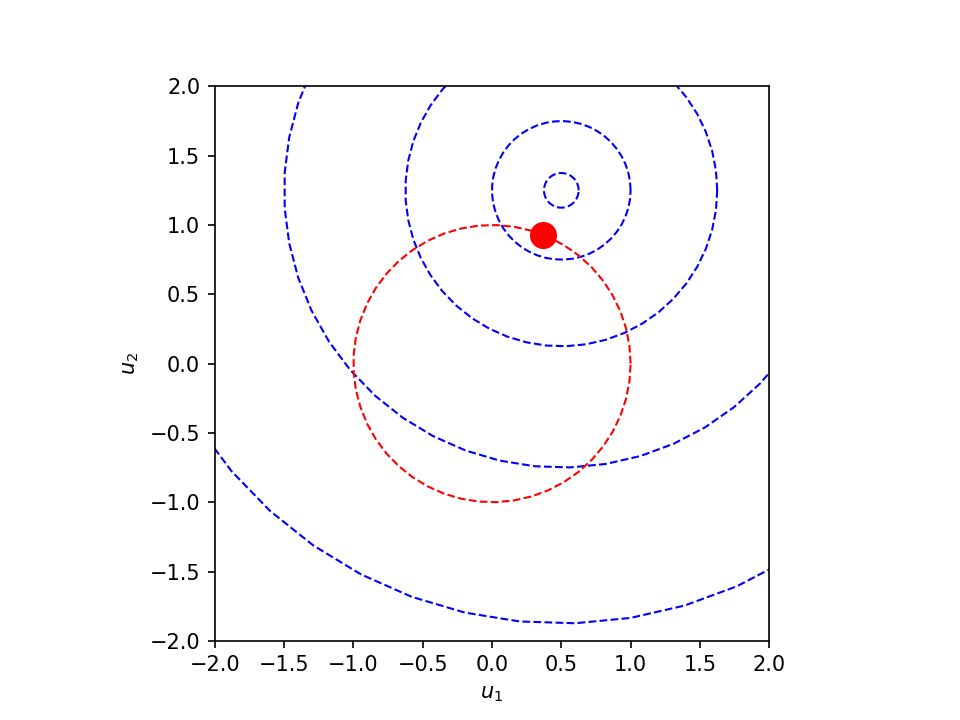

In [16]:
def viz_problem(x, y, ax):
    
    for r in [0.125, 0.5, 1.125, 2.0, 3.125]:
        ax.plot(r * np.cos(np.linspace(0.0, 2.0 * np.pi)) + 0.5, r * np.sin(np.linspace(0.0, 2.0 * np.pi)) + x, 'b--', linewidth=1)

    ax.plot(np.cos(np.linspace(0.0, 2.0 * np.pi)), np.sin(np.linspace(0.0, 2.0 * np.pi)), 'r--', linewidth=1)
    ax.plot(y[0], y[1], 'ro', markersize=12, linewidth=2)
    ax.set_xlabel(r"$u_1$"); ax.set_ylabel(r"$u_2$")

plt.figure()
a = plt.gca()
x = 1.25
y, _ = solve(np.array([0.5, x]))
viz_problem(x, y, a)
a.axis('square'); a.set_xlim(-2, 2); a.set_ylim(-2, 2)
plt.show()

Again, we can also compute the gradient using implicit differentiation. Now we have two-dimensional inputs and outputs. We also assume that our solver does not return $\lambda$ and so have to calculate it in the gradient function as

$$
\lambda = \frac{\text{D}_Y f(x, y)_i}{\text{D}_Y h(y)_i}
$$
for any $i$ such that $\text{D}_Y h(y)_i \neq 0.$

The gradient is
$$
\begin{align*}
\text{D} y
&= \left( \frac{H^{-1}aa^TH^{-1}}{a^T H^{-1} a} - H^{-1}\right) B \\
&= \frac{1}{v^T a} v v^T B - W
\end{align*}
$$
where $v = H^{-1}a$ and $W = H^{-1}B$, and which we have implemented below using automatic differentiation.

In [17]:
# gradient by implicit differentiation

fY = grad(f, 1)
hY = grad(h)
fXY = jacobian(fY, 0)
fYY = jacobian(fY, 1)
hYY = jacobian(hY, 0)

def dy(x):
    """Compute gradient of y with respect to x using implicit differentiation."""

    y, nu = solve(x)
    
    a = hY(y)
    b = fXY(x, y)
    if (nu is None):
        indx = np.nonzero(a)[0]
        nu = 0 if (len(indx) == 0) else fY(x, y)[indx[0]] / a[indx[0]] 

    H = fYY(x, y) - nu * hYY(y)
    
    # Here we solve a systems of linear equations rather than inverting H.
    # We first cholesky factor H into LL^T and then solve for v and W.
    C, L = cho_factor(H)
    v = cho_solve((C, L), a) # v = H^{-1} a
    w = cho_solve((C, L), b) # w = H^{-1} b
    return np.outer(v, v.dot(b) / v.dot(a)) - w

In [18]:
# generate data for different input
x = np.linspace(-2.0, 2.0, num=51)
y = [solve(np.array([0.5, xi]))[0] for xi in x]
dy_analytic = [dy_closed_form(np.array([0.5, xi])) for xi in x]
dy_implicit = [dy(np.array([0.5, xi])) for xi in x]

# print difference between analytic and implicit gradients
err = np.abs(np.array(dy_analytic) - np.array(dy_implicit))
print("Max. difference between implicit and analytic gradients is {}".format(np.max(err)))

Max. difference between implicit and analytic gradients is 4.996003610813204e-16


In [19]:
# simple animation of the problem

def init():
    for a in ax:
        a.axis('square')
        a.set_xlim(x[0], x[-1])    
    ax[0].set_ylim(x[0], x[-1])
    ax[1].set_ylim(-1.0, 1.0)
    ax[2].set_ylim(-1.0, 1.0)

    return ax


def animate(fnum, x, y, dy):
    
    for a in ax:
        a.clear()

    viz_problem(x[fnum], y[fnum], ax[0])

    ax[1].plot(x[0:fnum], [yi[0] for yi in y[0:fnum]], x[0:fnum], [yi[1] for yi in y[0:fnum]])
    ax[1].legend([r"$y_1$", r"$y_2$"])
    
    ax[2].plot(x[0:fnum], [di[0, 0] for di in dy[0:fnum]], x[0:fnum], [di[0, 1] for di in dy[0:fnum]],
               x[0:fnum], [di[1, 0] for di in dy[0:fnum]], x[0:fnum], [di[1, 1] for di in dy[0:fnum]])
    ax[2].legend([r"$Dy_{1,1}$", r"$Dy_{1,2}$", r"$Dy_{2,1}$", r"$Dy_{2,2}$"], loc='upper left')
    ax[2].set_xlabel(r"$x_2$");
    
    for a in ax:
        a.axis('square')
        a.set_xlim(x[0], x[-1])
    ax[0].set_ylim(x[0], x[-1])
    ax[1].set_ylim(-1.0, 1.0)
    ax[2].set_ylim(-1.0, 1.0)
    
    return ax


In [20]:
%%capture
fig = plt.figure()
ax = [plt.subplot(1, 2, 1), plt.subplot(2, 2, 2), plt.subplot(2, 2, 4)]
plt.suptitle(r"$y$ = argmin $\frac{1}{2} u^T u - x^T u$ subject to $\|u\|^2 = 1$")

ani = animation.FuncAnimation(fig, animate, init_func=init, fargs=(x, y, dy_analytic),
                              interval=100, frames=len(x), blit=False, repeat=False)

plt.close(fig)

In [21]:
# display using video or javascript
HTML(ani.to_html5_video())
#HTML(ani.to_jshtml())

## Example 4: Minimize quadratic objective over unit ball

Similar to above but relaxing the equality constraint to an inequality constraint, consider the problem
$$
\begin{array}{rll}
y(x) =& \text{argmin}_u & \frac{1}{2} u^T u - x^T u
\\
& \text{subject to} & \|u\|_2^2 \leq 1
\end{array}
$$
which is equilavent to projecting the point $u$ onto the unit ball.

The problem has analytic solution
$$
\begin{align*}
y &= \begin{cases}
x & \text{if $\|x\| \leq 1$} \\
\frac{1}{\|x\|} x & \text{otherwise}
\end{cases}
\end{align*}
$$
and gradient
$$
\begin{align*}
\text{D} y &= \begin{cases}
I & \text{if $\|x\| < 1$} \\
\frac{1}{\|x\|^3} \begin{bmatrix}
    x_2^2 & - x_1 x_2
    \\
    - x_1 x_2 & x_1^2
\end{bmatrix}
& \text{if $\|x\| > 1$}
\end{cases}
\end{align*}
$$
and undefined for $\|x\| = 1$.

In [22]:
# objective and constraint functions

def f(x, u):
    """Objective function taking x \in \reals^2, u \in \reals^2."""
    return 0.5 * np.dot(u, u) - np.dot(u, x)

def h(u):
    """Constraint function taking u \in \reals^2."""
    return np.dot(u, u) - 1.0

# analytical solutions

def solve(x):
    """Analytical solution to min. f s.t. h = 0. Returns both optimal primal and dual variables."""
    d = np.dot(x, x)
    return x.copy() if (d <= 1.0) else 1.0 / np.sqrt(d) * x, None

def dy_closed_form(x):
    """Analytical derivative of y with respect to x."""
    d = np.dot(x, x)
    return np.eye(2, 2) if (d < 1.0) else 1.0 / np.power(d, 1.5) * np.array([[x[1] ** 2, -x[0]*x[1]], [-x[0]*x[1], x[0] ** 2]])

In [23]:
# gradient by implicit differentiation

fY = grad(f, 1)
hY = grad(h)
fXY = jacobian(fY, 0)
fYY = jacobian(fY, 1)
hYY = jacobian(hY, 0)

def dy(x):
    """Compute gradient of y with respect to x using implicit differentiation."""

    y, nu = solve(x)
    
    # use unconstrained gradient
    if (h(x) <= 0.0):
        return -1.0 * np.linalg.solve(fYY(x, y), fXY(x, y))
    
    # use constrained gradient
    a = hY(y)
    b = fXY(x, y)
    if (nu is None):
        indx = np.nonzero(a)[0]
        nu = 0.0 if (len(indx) == 0) else fY(x, y)[indx[0]] / a[indx[0]] 

    H = fYY(x, y) - nu * hYY(y)
    
    # Here we solve a systems of linear equations rather than inverting H.
    C, L = cho_factor(H)
    v = cho_solve((C, L), a) # v = H^{-1} a
    w = cho_solve((C, L), b) # w = H^{-1} b
    return np.outer(v, v.dot(b) / v.dot(a)) - w

In [24]:
# generate data for different input
x = np.linspace(-2.0, 2.0, num=51)
y = [solve(np.array([0.5, xi]))[0] for xi in x]
dy_analytic = [dy_closed_form(np.array([0.5, xi])) for xi in x]
dy_implicit = [dy(np.array([0.5, xi])) for xi in x]

# print difference between analytic and implicit gradients
err = np.abs(np.array(dy_analytic) - np.array(dy_implicit))
print("Max. difference between implicit and analytic gradients is {}".format(np.max(err)))

Max. difference between implicit and analytic gradients is 3.3306690738754696e-16


In [25]:
%%capture
fig = plt.figure()
ax = [plt.subplot(1, 2, 1), plt.subplot(2, 2, 2), plt.subplot(2, 2, 4)]
plt.suptitle(r"$y$ = argmin $\frac{1}{2} u^T u - x^T u$ subject to $\|u\|^2 \leq 1$")

ani = animation.FuncAnimation(fig, animate, init_func=init, fargs=(x, y, dy_analytic),
                              interval=100, frames=len(x), blit=False, repeat=False)

plt.close(fig)

In [26]:
# display using video or javascript
HTML(ani.to_html5_video())
#HTML(ani.to_jshtml())